<a href="https://colab.research.google.com/github/penkovgd/itmo-dl-course/blob/main/lab4_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этой лабораторной работе ваша задача состоит в ознакомлении с GAN.


In [ ]:
! pip install opendatasets -q

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import opendatasets as od

# 1. Генерация Fashion-MNIST

Первая задача - это простая отработка генеративной архитектуры. Необходимо, взяв за основу датасет https://www.kaggle.com/datasets/zalando-research/fashionmnist, получить на выходе сети подобные входным изображения. Архитектуру генератора и дискриминатора подбирайте самостоятельно.

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/zalando-research/fashionmnist'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: georgus
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist


100%|██████████| 68.8M/68.8M [00:00<00:00, 1.38GB/s]

X_train shape: (50000, 28, 28, 1)
X_val shape: (10000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


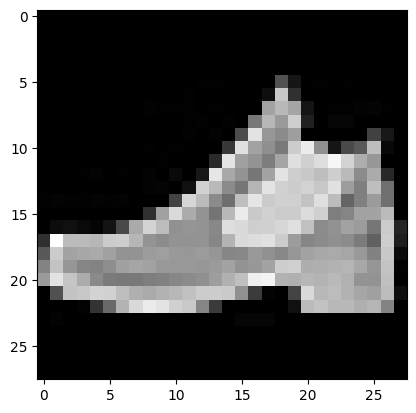

In [ ]:
train_df = pd.read_csv('/content/fashionmnist/fashion-mnist_train.csv')
test_df = pd.read_csv('/content/fashionmnist/fashion-mnist_test.csv')

X_train = train_df.iloc[:, 1:].values
y_train = train_df.iloc[:, 0].values

X_test = test_df.iloc[:, 1:].values
y_test = test_df.iloc[:, 0].values

X_train = X_train.reshape((X_train.shape[0], 28,28,1))
X_train = X_train / 255

X_test = X_test.reshape((X_test.shape[0], 28,28,1))
X_test = X_test / 255

X_train, X_val = X_train[:50_000], X_train[50_000:]
y_train, y_val = y_train[:50_000], y_train[50_000:]

plt.imshow(X_train[1], cmap='gray')
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

In [ ]:
discriminator = keras.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Conv2D(32, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Conv2D(64, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Conv2D(64, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])
discriminator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,001 (390.63 KB)

 Trainable params: 100,001 (390.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
latent_dim = 128

generator = keras.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(4 * 4 * 64),
    layers.Reshape((4,4,64)),
    layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Cropping2D(cropping=2),
    layers.Conv2D(1, kernel_size=4, padding='same', activation='sigmoid'),
])
generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 64)       │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       131,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 1)      │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 857,537 (3.27 MB)

 Trainable params: 857,537 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [ ]:
from PIL import Image

# Коллбэк, который сохраняет несколько сгенерированных фото после каждой эпохи,
# чтобы посмотреть на промежуточный результат
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

In [ ]:
epochs = 50
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0004),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
gan.build(input_shape=(None, latent_dim))
gan.fit(X_train, epochs=epochs, callbacks=[
    GANMonitor(num_img=3, latent_dim=latent_dim),
    keras.callbacks.ModelCheckpoint('gan.weights.h5', save_best_only=True, monitor='g_loss', save_weights_only=True),
    ], batch_size=128)

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 79ms/step - d_loss: 0.6595 - g_loss: 0.9799
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - d_loss: 0.4206 - g_loss: 1.5729
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - d_loss: 0.0813 - g_loss: 3.6261
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - d_loss: 0.0301 - g_loss: 6.4090
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - d_loss: 0.5651 - g_loss: 2.3183
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - d_loss: 0.6837 - g_loss: 0.7886
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - d_loss: 0.6921 - g_loss: 0.7731
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - d_loss: 0.6744 - g_loss: 0.7981
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - d_loss: 0.6777 - g_loss: 0.7862
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - d_loss: 0.6835 - g_loss: 0.7824
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - d_loss: 0.6794 - g_loss: 0.8328
Epoch 12/50
391/391 ━━━━━━━━━━

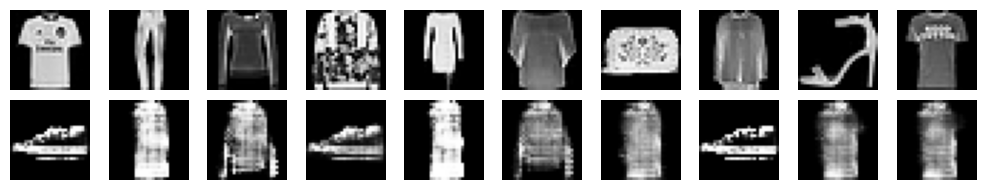

In [ ]:
real_images = X_test[:10]
random_latent_vectors = tf.random.normal(shape=(10, latent_dim))
generated_images = generator(random_latent_vectors)

fig, axes = plt.subplots(nrows=2, ncols=len(real_images), figsize=(10, 2))
plt.gray()
for i in range(len(real_images)):
    axes[0, i].imshow(real_images[i])
    axes[0, i].axis("off")
    axes[1, i].imshow(generated_images[i])
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

# 2. Повышение качества фото

Зачача №2 сосстоит в повышении качества изображения. Предлагается использовать две разные архитектуры: обычный автоэнкодер и генеративно-состязательную сеть. Здесь предлагается выбрать любой датасет, состоящий из изображений желательно в трех цветовых каналах, но можно взять и черно-белые, однако в любом случае исходные изображения должны быть в разрешении хотя бы 300х300 и представлять собой композиции (иначе говоря - быть "сложными". Подойдут, например, любые фотографии тех же кошек/собак). Датасет здесь состоит из изображений исходного размера, которые пойдут на выход, и их сжатых копий, которые пойдут на вход сети (просто скукожьте исходники с помощью resize в 2 или 4 раза). Отделите часть датасета для теста (не валидации!) и после обучения нейронной сети примените её к сжатым изображениям тестовой выборки. Результат применения выведете на экран. Не обязательно брать изображения в высоком разрешении,

Автоэнкодер:

## Автоэнкодер

Выбрал датасет про собак (https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset).

Там фото разных размеров, но мы приведем их к 512 на 512. Сожмем фото в 4 раза. Получим, что из картинки 128 на 128 нужно получить оригинальную в 512 пикселей.

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: georgus
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset


100%|██████████| 750M/750M [00:04<00:00, 185MB/s] 


In [ ]:
train_val_hires_dataset, test_hires_dataset = keras.utils.image_dataset_from_directory(
    '/content/stanford-dogs-dataset/images/Images',
    image_size=(512,512),
    batch_size=8,
    label_mode=None,
    validation_split=0.1,
    subset='both',
    seed=0,
)
train_hires_dataset = train_val_hires_dataset.take(int(0.8 * len(train_val_hires_dataset)))
val_hires_dataset = train_val_hires_dataset.skip(int(0.8 * len(train_val_hires_dataset)))

Found 20580 files.
Using 18522 files for training.
Using 2058 files for validation.


(8, 128, 128, 3)
(8, 512, 512, 3)


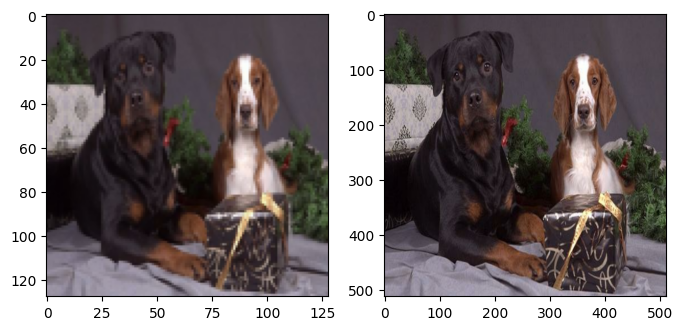

In [ ]:
def preprocess_image(image):
    low_res = tf.image.resize(image, [128, 128], method='area')
    low_res = low_res / 255.
    high_res = image / 255.
    return low_res, high_res

train_dataset = train_hires_dataset.map(preprocess_image)
val_dataset = val_hires_dataset.map(preprocess_image)
test_dataset = test_hires_dataset.map(preprocess_image)

fig,axes = plt.subplots(1,2, figsize=(8,4))
for x,y in train_dataset:
    print(x.shape)
    print(y.shape)
    img1 = x[0] * 255.
    img1 = img1.numpy().astype("uint8")
    img2 = y[0] * 255.
    img2 = img2.numpy().astype("uint8")
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    break


In [ ]:
model = keras.Sequential([
    # Encoder
    layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(128,128,3)),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.Conv2D(64, 3, activation='relu', padding='same'),

    # Decoder
    layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),  # 128x128
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),  # 256x256
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),  # 512x512
    layers.Conv2D(3, 3, activation='sigmoid', padding='same')
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_122 (Conv2D)         (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_123 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 conv2d_124 (Conv2D)         (None, 64, 64, 64)        36928     
                                                                 
 conv2d_transpose_35 (Conv2D  (None, 128, 128, 64)     36928     
 Transpose)                                                      
                                                                 
 conv2d_125 (Conv2D)         (None, 128, 128, 64)    

In [ ]:
from PIL import Image

class AEMonitor(keras.callbacks.Callback):
    def __init__(self, test_samples):
        super().__init__()
        self.test_samples = test_samples
    def on_epoch_end(self, epoch, logs=None):
        low_res, high_res = self.test_samples
        predictions = self.model.predict(low_res)
        for i in range(3):
            collage = Image.new('RGB', (512*3, 512))

            lr_img = Image.fromarray((low_res[i].numpy()*255).astype('uint8'))
            lr_img = lr_img.resize((512, 512), Image.NEAREST)
            collage.paste(lr_img, (0, 0))

            sr_img = Image.fromarray((predictions[i]*255).astype('uint8'))
            collage.paste(sr_img, (512, 0))

            hr_img = Image.fromarray((high_res[i].numpy()*255).astype('uint8'))
            collage.paste(hr_img, (1024, 0))

            collage.save(f"epoch_{epoch+1:03d}_sample_{i}.png")

In [ ]:
test_sample = next(iter(test_dataset.take(1)))

callbacks = [
    AEMonitor(test_sample),
    keras.callbacks.ModelCheckpoint('ae.h5', save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5)
]

history = model.fit(
    train_dataset,
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    validation_data=val_dataset,
)

Epoch 1/20
463/463 [==============================] - 77s 165ms/step - loss: 0.0109 - val_loss: 0.0044
Epoch 2/20
463/463 [==============================] - 77s 166ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 3/20
463/463 [==============================] - 76s 163ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 4/20
463/463 [==============================] - 77s 165ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 5/20
463/463 [==============================] - 77s 165ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/20
463/463 [==============================] - 76s 165ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 7/20
463/463 [==============================] - 77s 165ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/20
463/463 [==============================] - 76s 165ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 9/20
463/463 [==============================] - 76s 164ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 10/20
463/463 [==============================] - 77s 167ms/step - l

1/1 [==============================] - 0s 61ms/step


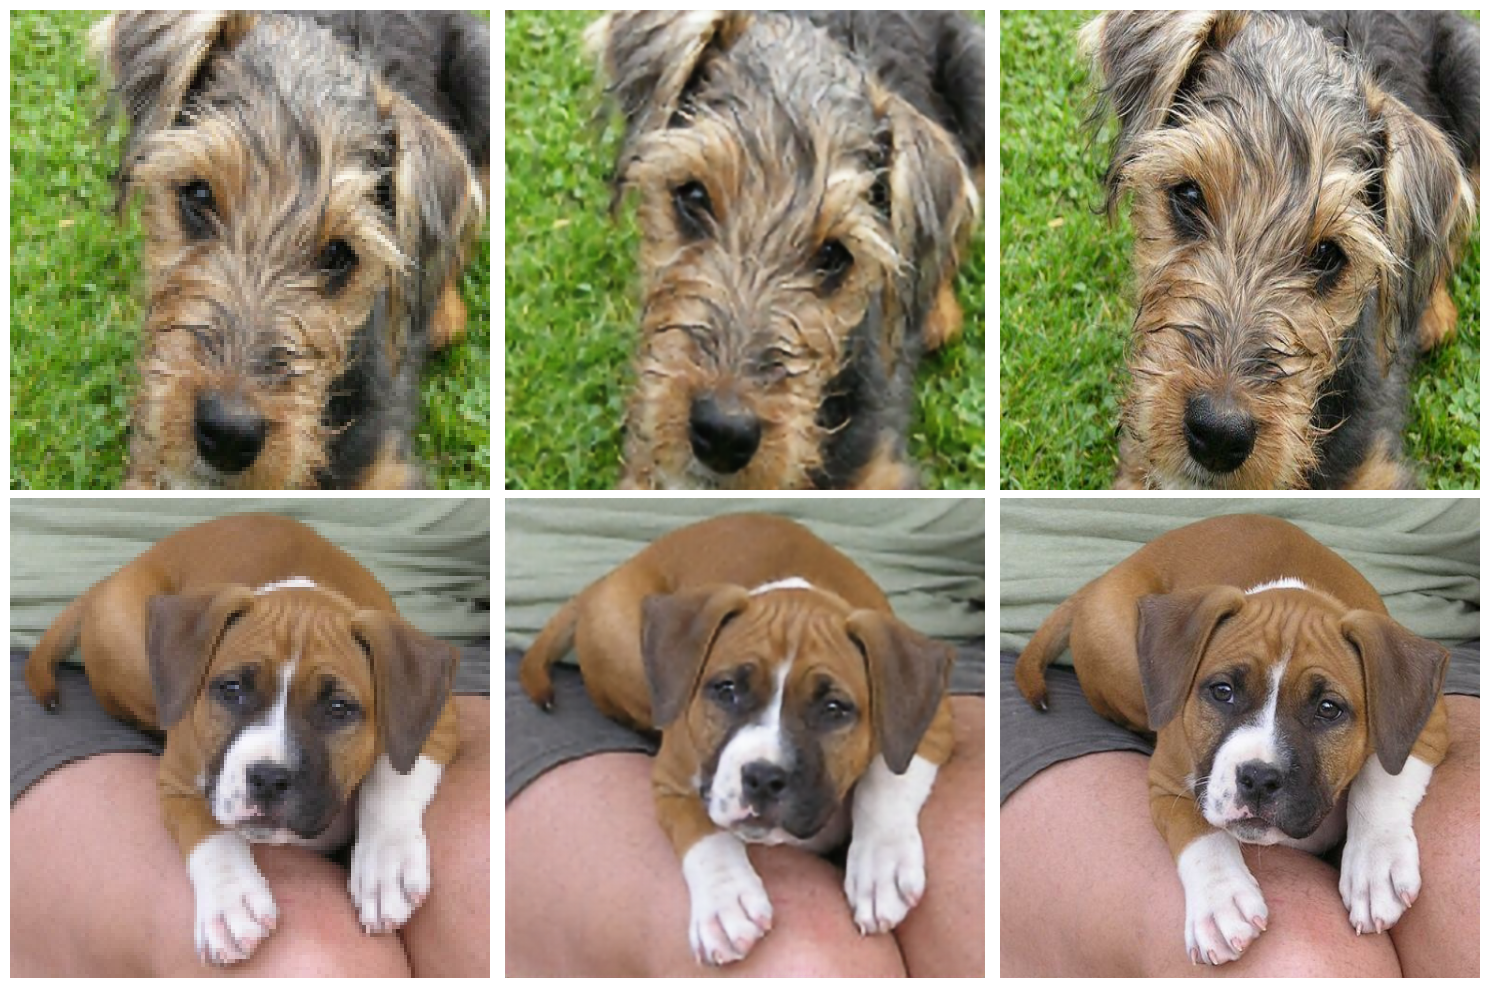

In [ ]:
ae_best = keras.models.load_model('ae.h5')

low_res, high_res = next(iter(test_dataset.take(1)))
predictions = ae_best.predict(low_res)

fig, axes = plt.subplots(2, 3, figsize=(15,10))

for i in range(2):
    low_res_img = (low_res[i+5].numpy() * 255).astype('uint8')
    high_res_img = (high_res[i+5].numpy() * 255).astype('uint8')
    pred_img = (predictions[i+5] * 255).astype('uint8')
    axes[i, 0].imshow(low_res_img)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(pred_img)
    axes[i, 1].axis('off')
    axes[i, 2].imshow(high_res_img)
    axes[i, 2].axis('off')
plt.tight_layout()

## GAN

GAN:

In [ ]:
generator = keras.Sequential([
    layers.Input(shape=(128,128,3)),
    layers.Conv2D(32, kernel_size=9, padding='same'),
    layers.LeakyReLU(0.2),

    layers.UpSampling2D(),
    layers.Conv2D(32, kernel_size=3, padding='same'),
    layers.LeakyReLU(0.2),

    layers.UpSampling2D(),
    layers.Conv2D(32, kernel_size=3, padding='same'),
    layers.LeakyReLU(0.2),

    layers.Conv2D(3, kernel_size=9, padding='same', activation='sigmoid'),
])
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 512, 512, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 512, 512, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 512, 512, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 512, 512, 3)    │         7,779 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,083 (133.14 KB)

 Trainable params: 34,083 (133.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
discriminator = keras.Sequential([
    layers.Input(shape=(512,512,3)),
    layers.Conv2D(16, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Conv2D(32, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Conv2D(32, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 16)   │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,497 (611.32 KB)

 Trainable params: 156,497 (611.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class GAN_Upscale(keras.Model):
    def __init__(self, discriminator, generator, adv_loss_weight=0.001):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.adv_loss_weight = adv_loss_weight

        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')

    def compile(self, d_optimizer, g_optimizer, adv_loss_fn, pixel_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.adv_loss_fn = adv_loss_fn
        self.pixel_loss_fn = pixel_loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, images_pairs):
        lr_images, hr_images = images_pairs
        batch_size = tf.shape(lr_images)[0]

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            generated_hr_images = self.generator(lr_images, training=True)

            real_logits = self.discriminator(hr_images, training=True)
            fake_logits = self.discriminator(generated_hr_images, training=True)

            d_loss_real = self.adv_loss_fn(tf.ones_like(real_logits), real_logits)
            d_loss_fake = self.adv_loss_fn(tf.zeros_like(fake_logits), fake_logits)
            d_loss = 0.5 * (d_loss_fake + d_loss_real)

            pixel_loss = self.pixel_loss_fn(hr_images, generated_hr_images)
            adv_loss = self.adv_loss_fn(tf.ones_like(fake_logits), fake_logits)
            g_loss = pixel_loss + self.adv_loss_weight * adv_loss

        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)

        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [ ]:
from PIL import Image

class GAN_Upscale_Monitor(keras.callbacks.Callback):
    def __init__(self, test_samples):
        super().__init__()
        self.test_samples = test_samples
    def on_epoch_end(self, epoch, logs=None):
        low_res, high_res = self.test_samples
        predictions = self.model.generator(low_res)
        for i in range(3):
            collage = Image.new('RGB', (512*3, 512))

            lr_img = Image.fromarray((low_res[i].numpy()*255).astype('uint8'))
            lr_img = lr_img.resize((512, 512), Image.NEAREST)
            collage.paste(lr_img, (0, 0))

            sr_img = Image.fromarray((predictions[i].numpy()*255).astype('uint8'))
            collage.paste(sr_img, (512, 0))

            hr_img = Image.fromarray((high_res[i].numpy()*255).astype('uint8'))
            collage.paste(hr_img, (1024, 0))

            collage.save(f"epoch_{epoch+1:03d}_sample_{i}.png")

In [ ]:
test_sample = next(iter(test_dataset.take(1)))

epochs = 20
gan = GAN_Upscale(discriminator=discriminator, generator=generator, adv_loss_weight=0.001)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    adv_loss_fn=keras.losses.BinaryCrossentropy(),
    pixel_loss_fn=keras.losses.MeanSquaredError(),
)
gan.fit(train_dataset, epochs=epochs, callbacks=[
    GAN_Upscale_Monitor(test_sample),
    keras.callbacks.ModelCheckpoint('gan_upsample_weights.h5', save_best_only=True, monitor='g_loss', save_weights_only=True),
    keras.callbacks.EarlyStopping(patience=5, monitor='g_loss')
    ])

Epoch 1/20
1852/1852 [==============================] - 261s 140ms/step - d_loss: 0.2775 - g_loss: 0.0051
Epoch 2/20
1852/1852 [==============================] - 261s 141ms/step - d_loss: 0.2476 - g_loss: 0.0053
Epoch 3/20
1852/1852 [==============================] - 262s 142ms/step - d_loss: 0.2437 - g_loss: 0.0053
Epoch 4/20
1852/1852 [==============================] - 262s 142ms/step - d_loss: 0.2590 - g_loss: 0.0053
Epoch 5/20
1852/1852 [==============================] - 261s 141ms/step - d_loss: 0.2779 - g_loss: 0.0053
Epoch 6/20
1852/1852 [==============================] - 262s 142ms/step - d_loss: 0.2553 - g_loss: 0.0053
Epoch 7/20
1852/1852 [==============================] - 260s 140ms/step - d_loss: 0.2658 - g_loss: 0.0053
Epoch 8/20
1852/1852 [==============================] - 260s 140ms/step - d_loss: 0.2628 - g_loss: 0.0053
Epoch 9/20
1852/1852 [==============================] - 260s 140ms/step - d_loss: 0.2598 - g_loss: 0.0055
Epoch 10/20
1852/1852 [=======================

In [ ]:
gan.load_weights(filepath='/content/gan_upsample_weights.h5') # эту модель обучал локально, в колаб загрузил обученные веса

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


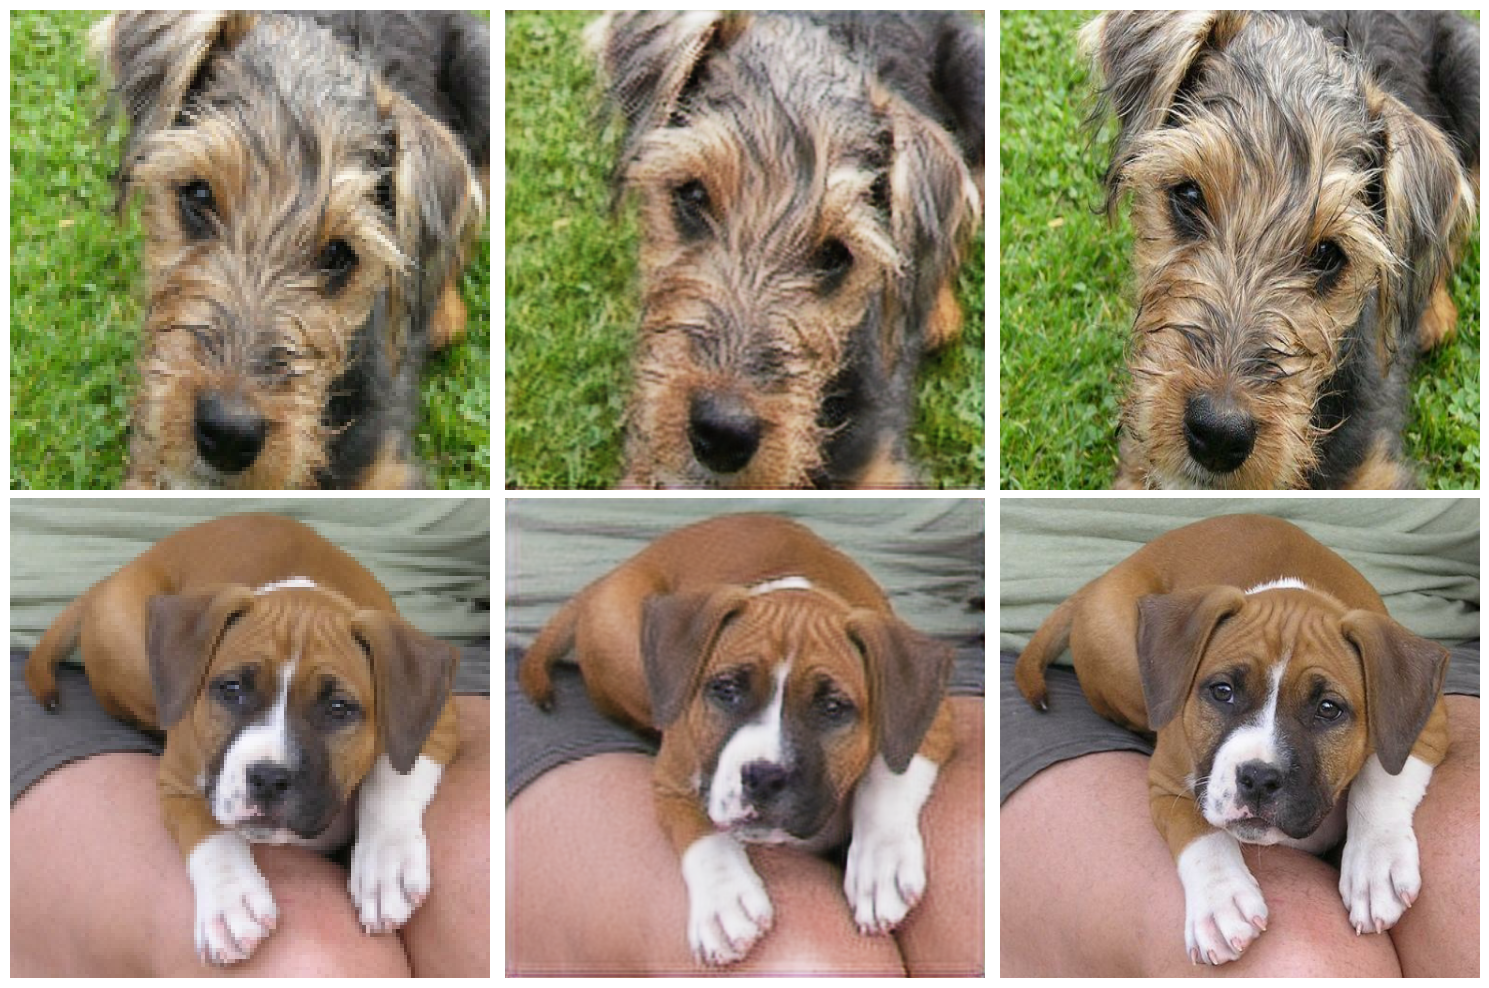

In [ ]:
low_res, high_res = next(iter(test_dataset.take(1)))

predictions_gan = gan.generator.predict(low_res)

fig, axes = plt.subplots(2, 3, figsize=(15,10))

for i in range(2):
    low_res_img = (low_res[i+5].numpy() * 255).astype('uint8')
    high_res_img = (high_res[i+5].numpy() * 255).astype('uint8')
    pred_img = (predictions[i+5] * 255).astype('uint8')
    axes[i, 0].imshow(low_res_img)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(pred_img)
    axes[i, 1].axis('off')
    axes[i, 2].imshow(high_res_img)
    axes[i, 2].axis('off')
plt.tight_layout()